## NaiveBayes on all 364k cleaned data points with BoW and TF-IDF

In [1]:
%%time
import sqlite3
import warnings
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
##############################

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


##############################

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

##############################

import re
import gensim
import random
import time
import datetime

##############################

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

##############################

from sklearn.naive_bayes import MultinomialNB



CPU times: user 1.76 s, sys: 1.1 s, total: 2.85 s
Wall time: 1.44 s


In [2]:
%%time

#creating the connection object towards database file
import sqlite3
con = sqlite3.connect('database.sqlite')

#removing the reviews ==3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """,con)
filtered_data['Score'] = filtered_data['Score'].apply(lambda x : 'Positive' if int(x) > 3 else 'Negative')
print(filtered_data['Score'].value_counts())

#droping duplicate values:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False)
final = sorted_data.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'], keep='first')
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]

len(final)

Positive    443777
Negative     82037
Name: Score, dtype: int64
CPU times: user 5.3 s, sys: 668 ms, total: 5.97 s
Wall time: 5.97 s


## sorting database based on the 'Time' column

In [3]:
#sorting dataframe based on time:
final = final.sort_values('Time')

## initial preprocessing steps:

In [4]:
%%time
# removeing HTML TAG
final['Text'] = final['Text'].apply(lambda x : re.sub('<.*?>',' ', x))

#removing punctuation marks:
final['Text'] = final['Text'].apply(lambda x: re.sub(r'[?|!|\'|"|#|.|\,|)|(|\|/|:|-]', r' ', x))

#converting it to lower case:
final['Text'] = final['Text'].apply(lambda x: x.lower())


CPU times: user 4.72 s, sys: 104 ms, total: 4.82 s
Wall time: 4.82 s


In [5]:
%%time
#creating stopwords list:

stop = set(stopwords.words('english')) #set of stopwords
stop = list(stop)
temp = []
for i in range(len(stop)):
    if stop[i] in ('shouldn', 'should', 'off', 'must', "shouldn't", "wouldn't", "needn't", "doesn't", 'not', 'very','ain','mightn',"needn't"):
        continue
    else:
        temp.append(stop[i])
stop = set(temp)

#Creating an instance of SnowballStemmer class
sno = nltk.stem.SnowballStemmer('english') 

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.01 ms


In [6]:
%%time

#creating list of cleaned words and two seperate lists of pos & neg reviews
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sentence in final['Text'].values:
    filtered_sentence=[]
    for word in sentence.split():
        if((word not in stop) & (len(word)>2) & (word.isalpha())):    
            s = sno.stem(word).encode('utf8')
            filtered_sentence.append(s)
            if (final['Score'].values)[i] == 'Positive': 
                all_positive_words.append(s) #list of all words used to describe positive reviews
            elif(final['Score'].values)[i] == 'Negative':
                all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        else:
            continue
 #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("*" * 40)
    
    final_string.append(str1)
    i+=1
            

CPU times: user 5min 12s, sys: 732 ms, total: 5min 13s
Wall time: 5min 13s


In [7]:
# creating a column of cleaned text after data preprocessing:

final['CleanedText'] = final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText'] = final['CleanedText'].str.decode("utf-8")

In [8]:
final.iloc[:, -2:].head(8)

,Text,CleanedText
138706,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,i can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,beetlejuice is a well written movie ever...,beetlejuic well written movi everyth excel act...
346055,a twist of rumplestiskin captured on film sta...,twist rumplestiskin captur film star michael k...
417838,beetlejuice is an excellent and funny movie k...,beetlejuic excel funni movi keaton hilari wack...
346116,this is one movie that should be in your movie...,one movi should movi collect fill comedi actio...
346041,i myself always enjoyed this movie it s very...,alway enjoy movi veri funni entertain hesit pi...
70688,i bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...


## train test split with NO random shuffling

In [9]:
%%time

#saving scores in variable and splitting into train and test data sets
y = final['Score']
from sklearn.model_selection import train_test_split
#train test split
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values, y, test_size=0.3, shuffle=False)

CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 38.3 ms


In [10]:
len(X_train)

254919

In [11]:
uniq_words = set(X_train)
len(uniq_words)

254248

## to check whether time based split happened correctly or not

In [12]:
print(final['CleanedText'].head(1) == X_train[0])
print('***************************************')
print(final['CleanedText'].tail(1) == X_test[-1])

138706    True
Name: CleanedText, dtype: bool
***************************************
355171    True
Name: CleanedText, dtype: bool


## BoW vectorizer

In [13]:
%%time
#creating instance of BoW class, fitting and transforming to both trining and test dataset:

BoW_vect = CountVectorizer(ngram_range=(1,1)) 

X_train = BoW_vect.fit_transform(X_train)
X_test = BoW_vect.transform(X_test)

CPU times: user 14.4 s, sys: 244 ms, total: 14.6 s
Wall time: 14.6 s


In [14]:
%%time

print("the type of count vectorizer ",type(X_train))
print("the shape of out training BOW vectorizer ",X_train.shape)
print("the shape of out test BOW vectorizer ",X_test.shape)
print('train data size on RAM is {} bytes'.format(sys.getsizeof(X_train)))
print('test data size on RAM is {} bytes'.format(sys.getsizeof(X_test)))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out training BOW vectorizer  (254919, 58961)
the shape of out test BOW vectorizer  (109252, 58961)
train data size on RAM is 56 bytes
test data size on RAM is 56 bytes
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 674 µs


## CV for finding optimal alpha

In [15]:
%%time

#creating empty list for holding different CV scores:
cv_score = []
alph_range = np.arange(1,25) 
    
# perform 10-fold cross validation:

for i in alph_range:
    clf = MultinomialNB(alpha = i)
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_score.append(scores.mean())

CPU times: user 4min 27s, sys: 19.7 s, total: 4min 47s
Wall time: 4min 47s


Optimal alpha for NB-BoW = 3
missclassification error for each alpha value:  [0.098 0.095 0.094 0.096 0.099 0.103 0.107 0.111 0.115 0.119 0.122 0.126
 0.129 0.131 0.133 0.135 0.137 0.138 0.14  0.141 0.142 0.143 0.144 0.144]


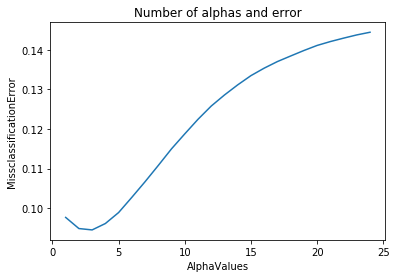

CPU times: user 320 ms, sys: 188 ms, total: 508 ms
Wall time: 444 ms


In [18]:
%%time
# to calculate misclassification error:

MSE = [1 - x for x in cv_score]
alpha_optimal_BoW = alph_range[MSE.index(min(MSE))]

print('Optimal alpha for NB-BoW = {}'.format(alpha_optimal_BoW))
print("missclassification error for each alpha value: ", np.round(MSE, 3))

#plotting the graph of misclassification error vs alpha

plt.plot(alph_range, MSE)
plt.title("Number of alphas and error")
plt.xlabel("AlphaValues")
plt.ylabel("MissclassificationError")
plt.show()


## NB algorithm on optimal alpha found using CV

In [19]:
# instantiateing the model with optimal alpha found
nb_optimal_BoW =  MultinomialNB(alpha = alpha_optimal_BoW)

# fitting the model
nb_optimal_BoW.fit(X_train, y_train)

# predicting the response
ypred = nb_optimal_BoW.predict(X_test)

In [20]:
# To get all the features name 

bow_features = BoW_vect.get_feature_names()
print(len(bow_features))
print(type(bow_features))

58961
<class 'list'>


In [21]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal_BoW.feature_count_
print(feat_count.shape)
print()
for i in feat_count:
    print(i)
    break

(2, 58961)

[0. 1. 0. ... 0. 0. 0.]


In [22]:
# log probability of features given a class

log_prob = nb_optimal_BoW.feature_log_prob_
log_prob

array([[-13.29080291, -13.00312084, -13.29080291, ..., -13.29080291,
        -13.29080291, -13.29080291],
       [-14.56749311, -12.73491165, -14.56749311, ..., -14.56749311,
        -14.56749311, -14.56749311]])

In [23]:
#creating data frames of the features calculated:
features_prob_df = pd.DataFrame(log_prob, columns = bow_features)
print(features_prob_df.shape)
print()
features_prob_df.head(8)

(2, 58961)



,aa,aaa,aaaa,aaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaargh,aaaaaaaaagghh,aaaaaaahhhhhh,aaaaaaarrrrrggghhh,aaaaaah,...,zziga,zzz,zzzzz,zzzzzz,zzzzzzz,zzzzzzzz,zzzzzzzzzz,zzzzzzzzzzz,çay,çaykur
0,-13.290803,-13.003121,-13.290803,-13.290803,-13.290803,-13.290803,-13.290803,-13.290803,-13.003121,-13.290803,...,-13.290803,-13.290803,-13.290803,-13.290803,-13.003121,-13.290803,-13.290803,-13.290803,-13.290803,-13.290803
1,-14.567493,-12.734912,-14.567493,-14.567493,-14.567493,-14.567493,-14.567493,-14.567493,-14.855175,-14.344350,...,-14.567493,-14.007877,-14.344350,-14.567493,-14.567493,-14.567493,-14.567493,-14.567493,-14.567493,-14.567493


In [24]:
#transposing the data frame created above so as to see log wise feature importance of features

feature_prob_tr = features_prob_df.T
print(feature_prob_tr.head(4))

               0          1
aa    -13.290803 -14.567493
aaa   -13.003121 -12.734912
aaaa  -13.290803 -14.567493
aaaaa -13.290803 -14.567493


In [25]:
# To show top 20 feature from both class(Feature Importance)

print("Top 20 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:20])
print('*****************************************************************')
print("Top 20 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:20])

Top 20 Negative Features:-
 not       -3.906761
tast      -4.317114
like      -4.399337
product   -4.571867
one       -4.846395
flavor    -4.878896
would     -5.002855
tri       -5.006215
veri      -5.043321
good      -5.158488
coffe     -5.179075
use       -5.193681
get       -5.274155
buy       -5.275696
order     -5.322714
food      -5.370962
tea       -5.390660
box       -5.471568
even      -5.488185
amazon    -5.526507
Name: 0, dtype: float64
*****************************************************************
Top 20 Positive Features:-
 not       -4.412527
like      -4.464909
tast      -4.531159
good      -4.674094
flavor    -4.687261
love      -4.729291
great     -4.746423
use       -4.769769
one       -4.820352
veri      -4.893434
product   -4.904931
tea       -4.915243
tri       -4.941869
coffe     -5.048052
make      -5.058846
get       -5.123544
food      -5.237660
time      -5.376285
would     -5.408236
buy       -5.413802
Name: 1, dtype: float64


In [27]:
# Accuracy on training data
train_acc_bow = nb_optimal_BoW.score(X_train, y_train)
print("Train accuracy is {}".format(train_acc_bow))


Train accuracy is 0.9133057951741533


In [28]:
# Error on training data
train_err_bow = 1 - train_acc_bow
print('Train Error is {}'.format(train_err_bow))

Train Error is 0.08669420482584667


In [30]:
# evaluating test accuracy:
acc_bow = accuracy_score(y_test, ypred) * 100
print('optimal accuracy for alpha = {} in BowNaiveBayesClassifier is {}'.format(alpha_optimal_BoW,acc_bow))

optimal accuracy for alpha = 3 in BowNaiveBayesClassifier is 89.86929301065427


## Performace metrics(confusion matrix, f1-Score, Accuracy, Precision, Recall)

In [32]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, ypred)
print(cm)

[[11457  7624]
 [ 3444 86727]]


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


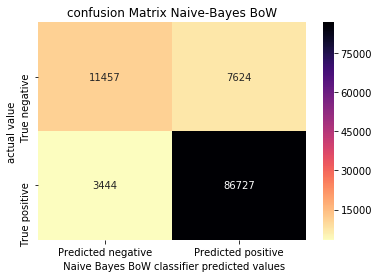

In [34]:
%time
#creating confusion matrix heatmap plot:

cf = confusion_matrix(y_test, ypred)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix Naive-Bayes BoW")
plt.xlabel(" Naive Bayes BoW classifier predicted values")
plt.ylabel("actual value")
plt.show()



## Recall metric

In [36]:
# Recall- True Positive Rate TPR = TP/TP+FN
TPR = cm[1,1] / (cm[0,1] + cm[1,1])
print('recall is {}'.format(TPR))

recall is 0.919195345041388


## Classification Report:

In [37]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred))

             precision    recall  f1-score   support

   Negative       0.77      0.60      0.67     19081
   Positive       0.92      0.96      0.94     90171

avg / total       0.89      0.90      0.89    109252



## TF-IDF Naive Bayes without random shuffling


In [38]:
%%time

#saving scores in variable and splitting into train and test data sets
y = final['Score']
from sklearn.model_selection import train_test_split
#train test split
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values, y, test_size=0.3, shuffle=False)

CPU times: user 44 ms, sys: 8 ms, total: 52 ms
Wall time: 50.9 ms


In [39]:
%%time
#fitting tfidf vectorizor into training data:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
X_train = tf_idf_vect.fit_transform(X_train)
X_train.shape

CPU times: user 9.97 s, sys: 316 ms, total: 10.3 s
Wall time: 10.3 s


In [40]:
# Convert test text data to its tfidf vectorizor array
X_test = tf_idf_vect.transform(X_test)
X_test.shape

(109252, 58961)

## using cross validation for finding optimal alpha

In [41]:
%%time

#creating empty list for holding different CV scores:
cv_score = []
alph_range = np.arange(1,25) 
    
# perform 10-fold cross validation:

for i in alph_range:
    clf = MultinomialNB(alpha = i)
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_score.append(scores.mean())

CPU times: user 4min 28s, sys: 6.64 s, total: 4min 34s
Wall time: 4min 34s


Optimal alpha for NB-Tf-Idf is = 1
missclassification error for each alpha value:  [0.139 0.146 0.148 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149
 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149]


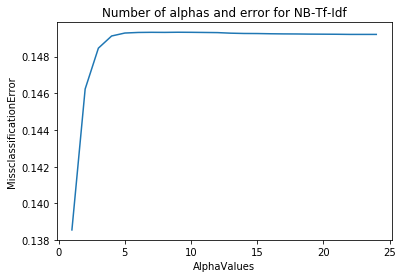

CPU times: user 268 ms, sys: 220 ms, total: 488 ms
Wall time: 183 ms


In [42]:
%%time
# to calculate misclassification error:

MSE = [1 - x for x in cv_score]
alpha_optimal_tf_idf = alph_range[MSE.index(min(MSE))]

print('Optimal alpha for NB-Tf-Idf is = {}'.format(alpha_optimal_tf_idf))
print("missclassification error for each alpha value: ", np.round(MSE, 3))

#plotting the graph of misclassification error vs alpha

plt.plot(alph_range, MSE)
plt.title("Number of alphas and error for NB-Tf-Idf")
plt.xlabel("AlphaValues")
plt.ylabel("MissclassificationError")
plt.show()

## Naive Bayes on optimal alpha found for TF-IDF

In [44]:
# instantiate learning model alpha = optimal_alpha
nb_optimal_tf_idf =  MultinomialNB(alpha = alpha_optimal_tf_idf)

# fitting the model
nb_optimal_tf_idf.fit(X_train, y_train)

# predicting the response
ypred = nb_optimal_tf_idf.predict(X_test)

In [58]:
# To get all the features name for tf-idf
tf_idf_features = tf_idf_vect.get_feature_names()
print(type(tf_idf_features))
print(len(tf_idf_features))


<class 'list'>
58961


In [59]:
# To count feature for each feature/class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal_tf_idf.feature_count_
print(feat_count.shape)
print()
for i in feat_count:
    print(i)
    break

(2, 58961)

[0.         0.21697339 0.         ... 0.         0.         0.        ]


In [60]:
# finding log probability of features given class label

log_prob = nb_optimal_tf_idf.feature_log_prob_
log_prob

array([[-12.39729773, -12.20093078, -12.39729773, ..., -12.39729773,
        -12.39729773, -12.39729773],
       [-13.55950973, -12.46880109, -13.52681892, ..., -13.71373367,
        -13.59525024, -13.50938661]])

In [61]:
#creating data frame of the log probability of features calculated above:
features_prob_df = pd.DataFrame(log_prob, columns = tf_idf_features)
print(features_prob_df.shape)
print('*************************************')
features_prob_df.head(8)

(2, 58961)
*************************************


,aa,aaa,aaaa,aaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaargh,aaaaaaaaagghh,aaaaaaahhhhhh,aaaaaaarrrrrggghhh,aaaaaah,...,zziga,zzz,zzzzz,zzzzzz,zzzzzzz,zzzzzzzz,zzzzzzzzzz,zzzzzzzzzzz,çay,çaykur
0,-12.397298,-12.200931,-12.397298,-12.397298,-12.397298,-12.397298,-12.397298,-12.397298,-12.236911,-12.397298,...,-12.397298,-12.397298,-12.397298,-12.397298,-12.026527,-12.397298,-12.397298,-12.397298,-12.397298,-12.397298
1,-13.559510,-12.468801,-13.526819,-13.603822,-13.471419,-13.568055,-13.486001,-13.724748,-13.886191,-13.521822,...,-13.671977,-13.151378,-13.348499,-13.743711,-13.659887,-13.830955,-13.661795,-13.713734,-13.595250,-13.509387


In [62]:
#transposing the data frame created above so as to see log wise feature importance of log probability of features:

feature_prob_tr = features_prob_df.T
print(feature_prob_tr.head(4))

               0          1
aa    -12.397298 -13.559510
aaa   -12.200931 -12.468801
aaaa  -12.397298 -13.526819
aaaaa -12.397298 -13.603822


In [63]:
# To show top 20 feature from both class(Feature Importance)

print("Top 20 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:20])
print('*****************************************************************')
print("Top 20 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:20])

Top 20 Negative Features:-
 not          -4.791218
tast         -5.103810
like         -5.255103
product      -5.311629
would        -5.606349
flavor       -5.612881
coffe        -5.628958
one          -5.646667
veri         -5.703716
tri          -5.748763
buy          -5.768768
order        -5.776118
box          -5.861992
tea          -5.898319
disappoint   -5.916835
good         -5.922031
get          -5.967307
use          -6.024912
even         -6.040797
bad          -6.073888
Name: 0, dtype: float64
*****************************************************************
Top 20 Positive Features:-
 great     -5.123227
love      -5.137601
tast      -5.195568
good      -5.201133
like      -5.215512
tea       -5.231189
not       -5.261029
flavor    -5.268847
coffe     -5.303545
veri      -5.372672
product   -5.374704
use       -5.391861
one       -5.470300
tri       -5.539445
make      -5.607093
get       -5.665099
price     -5.693562
best      -5.702364
buy       -5.726709
amazon    -5.7

In [64]:
# Accuracy on training data
train_acc_tf_idf = nb_optimal_tf_idf.score(X_train, y_train)
print("Train accuracy is {}".format(train_acc_tf_idf))


Train accuracy is 0.8666321458973243


In [65]:
# Error on training data
train_err_tf_idf = 1 - train_acc_tf_idf
print('Train Error is {}'.format(train_err_tf_idf))

Train Error is 0.1333678541026757


In [67]:
# evaluating test accuracy:
acc_tf_idf = accuracy_score(y_test, ypred) * 100
print('optimal accuracy for alpha = {} in TfIdf-NaiveBayes-Classifier is {}'.format(alpha_optimal_tf_idf,acc_tf_idf))

optimal accuracy for alpha = 1 in TfIdf-NaiveBayes-Classifier is 84.0414820781313


## TF-IDF Performace metrics(confusion matrix, f1-Score, Accuracy, Precision, Recall)

In [69]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, ypred)
print(cm)

[[ 1737 17344]
 [   91 90080]]


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


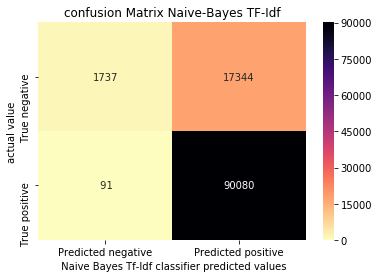

In [70]:
%time
#creating confusion matrix heatmap plot:

cf = confusion_matrix(y_test, ypred)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix Naive-Bayes TF-Idf")
plt.xlabel(" Naive Bayes Tf-Idf classifier predicted values")
plt.ylabel("actual value")
plt.show()



In [71]:
# Recall- True Positive Rate TPR = TP/TP+FN
TPR = cm[1,1] / (cm[0,1] + cm[1,1])
print('recall is {}'.format(TPR))

recall is 0.8385463211200477


In [72]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred))

             precision    recall  f1-score   support

   Negative       0.95      0.09      0.17     19081
   Positive       0.84      1.00      0.91     90171

avg / total       0.86      0.84      0.78    109252



## Conclusion:

1. when I took entire population of data  and did time spliting with no shuffling, below is the observation:

2. BoW Naive Bayes algorithm worked decent when having taken entire population of 361K data points with recall and f1-score 
   were about 60% for nevative predicted data points.
3. Tf-idf Naive bayes algorithm when tested with test data points, we could not see the recall and f1-score for negative
   predicted data points(~17%)